In [1]:
import numpy as np
from tool.utils import *
from models import *
import cv2
import torch
from torch import nn
import torch.nn.functional as F
import copy
from cfg import Cfg

In [2]:
model = Yolov4(n_classes=2)
pretrained_dict = torch.load('checkpoints/Yolov4_epoch300.pth', map_location=torch.device('cuda'))
model.load_state_dict(pretrained_dict)
model.cuda()

Yolov4(
  (down1): DownSample1(
    (conv1): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv2): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv3): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (conv4): Conv_Bn_Activation(
      (conv): ModuleList(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNo

In [12]:
    prec_list = []
    recall_list = []
    for conf_thres in range(5,10,1): #for nms_thres in range(1,10,1): 
        truth = {} 
        tp = np.zeros([2]) 
        fp = np.zeros([2]) 
        fn = np.zeros([2]) 
        tn = np.zeros([2]) 
        f = open('test.txt', 'r', encoding='utf-8') 
        for line in f.readlines(): 
            data = line.split(" ")
            #print(data[0])
            truth[data[0]] = [] 
            for i in data[1:]: 
                truth[data[0]].append([int(j) for j in i.split(',')]) 
            #print(data[0]) 
            gt=truth[data[0]] #print(gt)
            #print(data[0])
            img = cv2.imread('test/'+data[0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape
            #print(h, w)
            sized = cv2.resize(img, (Cfg.height, Cfg.width))
            boxes = do_detect(model, sized, conf_thres/10, 2, 0.4, 1)
            #print(boxes)

            # 模型偶爾沒辦法預測出bbox，塞入一個整張都是背景的bbox
            if len(boxes) == 0:
                #boxes = np.array([[0.5, 0.5, 1, 1, 1.0, 0.0, 0.0]])
                gt = np.array(gt)
                for i in gt[:,4]:
                    #print(i)
                    fn[i]+=1
                continue

            gt_normal=copy.deepcopy(gt)
            #print(type(gt))
            for count,val in enumerate(gt): #normalize
                gt_normal[count][0]=((val[2]+val[0])/2.0)/w
                gt_normal[count][1]=((val[3]+val[1])/2.0)/h
                gt_normal[count][2]=(val[2]-val[0])/w
                gt_normal[count][3]=(val[3]-val[1])/h

            #print(gt_normal)
            gt_normal=np.array(gt_normal)
            #print(gt_normal)
            gt_normal=torch.from_numpy(gt_normal)
            #print(gt_normal)
            #gt_normal=torch.tensor(gt_normal)
            boxes=torch.tensor(boxes)
            #print(gt)
            #ious=np.zeros((len(gt_normal),len(boxes)))
            ious=np.zeros((len(boxes),len(gt_normal)))
            #print(ious)
            #print(ious.shape)
            for cn1,i in enumerate(boxes): #ious
                for cn2,j in enumerate(gt_normal):
                    #print(ious.shape)
                    #print(cn2)
                    ious[cn1][cn2]=bbox_ious(i, j, x1y1x2y2=0)
            #print(ious)

            #開始算正確率
            #tp,fp,fn,tn=0,0,0,0
            #print('boxes')
            #print(boxes.size())
            boxes_cls=boxes[:,5:].numpy()
            boxes_cls_max=np.zeros([boxes.shape[0]], dtype=int)
            #print(boxes_cls_max.shape)
            for num,i in enumerate(boxes_cls):
                max_=0.0
                cn=0
                for index,j in enumerate(i):
                    if j>max_:
                        max_=j
                        cn=index
                boxes_cls_max[num]=cn
            #print(boxes_cls_max)
            #print(boxes_cls)
            for cn,i in enumerate(ious):
                count=0
                max_iou=0.0
                for index,j in enumerate(i) :
                    if j>max_iou:
                        count=index
                        max_iou=j
                #print(max_iou)
                if max_iou>=0.5:#若iou大於設定值，則參與計算正確率的計數器(TP、FP、FN、TN)中

                    #print('check1')
                    #Wear
                    if (gt_normal[count][4] == 0)&(boxes_cls_max[cn] == 0):
                        tp[0]+=1
                    elif (gt_normal[count][4] != 0)&(boxes_cls_max[cn] == 0):
                        fp[0]+=1
                    elif (gt_normal[count][4] == 0)&(boxes_cls_max[cn] != 0):
                        fn[0]+=1
                    elif (gt_normal[count][4] != 0)&(boxes_cls_max[cn] != 0):
                        tn[0]+=1
                    #NotWear
                    if (gt_normal[count][4] == 1)&(boxes_cls_max[cn] == 1):
                        tp[1]+=1
                    elif (gt_normal[count][4] != 1)&(boxes_cls_max[cn] == 1):
                        fp[1]+=1
                    elif (gt_normal[count][4] == 1)&(boxes_cls_max[cn] != 1):
                        fn[1]+=1
                    elif (gt_normal[count][4] != 1)&(boxes_cls_max[cn] != 1):
                        tn[1]+=1
                else:#等一下要改
                    #print(data[0])
                    if(boxes_cls_max[cn]==0):
                        #print('0')
                        fp[0]+=1
                    if(boxes_cls_max[cn]==1):
                        #print('1')
                        fp[1]+=1
            #print(data[0], tp, tn, fp, fn)


        print(tp+tn+fp+fn)
        acc = ((tp + tn)) / ((tp + tn + fp + fn))
        recall = tp / (tp+fn)
        prec = tp / (tp+fp)

        recall_list.append(recall)
        prec_list.append(prec)

        #print('with conf_thresh:{} acc={} recall={} prec={}'.format(conf_thres/10,acc,recall,prec))
        print('acc={} recall={} prec={}'.format(acc,recall,prec))

[616. 609.]
acc=[0.82305195 0.83251232] recall=[0.92156863 0.82720588] prec=[0.76839237 0.80357143]
[586. 573.]
acc=[0.82935154 0.84816754] recall=[0.91808874 0.83461538] prec=[0.77971014 0.83141762]
[540. 538.]
acc=[0.85555556 0.85873606] recall=[0.91039427 0.84897959] prec=[0.82736156 0.84210526]
[468. 472.]
acc=[0.86111111 0.85381356] recall=[0.89516129 0.83410138] prec=[0.85057471 0.84579439]
[389. 389.]
acc=[0.76092545 0.76092545] recall=[0.69266055 0.66820276] prec=[0.85310734 0.87349398]


(1, 2)


ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

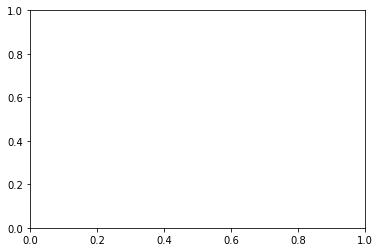

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
thresh = np.arange(1, 10) / 10
prec_list = np.array(prec_list)
recall_list = np.array(recall_list)
print(prec_list.shape)
plt.plot(thresh, prec_list[:, 0], marker = 'o')
plt.plot(thresh, recall_list[:, 0], marker = 'o')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
thresh = np.arange(1, 10) / 10
prec_list = np.array(prec_list)
recall_list = np.array(recall_list)
print(prec_list.shape)
plt.plot(thresh, prec_list[:, 1], marker = 'o')
plt.plot(thresh, recall_list[:, 1], marker = 'o')